# Data download

In [1]:
! curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
    
! gunzip ./*.gz

# Data inspection

In [2]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt

#### Load the data and cast lists as numpy array objects for faster processing.

In [3]:
mndata = MNIST('./')

images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels.tolist())

images_test, labels_test = mndata.load_testing()
images_test = np.array(images_test)
labels_test = np.array(labels_test.tolist())

#### Validate number of images and labels in training and validation (test) data, as well as length of vectorized first image array in training and validation datasets.

In [4]:
print(len(images), len(labels))
print(len(images_test), len(labels_test))

print(len(images[0]))
print(len(images_test[0]))

60000 60000
10000 10000
784
784


#### Plot first instance of each digit type in training dataset.

In [5]:
# ! mkdir plots

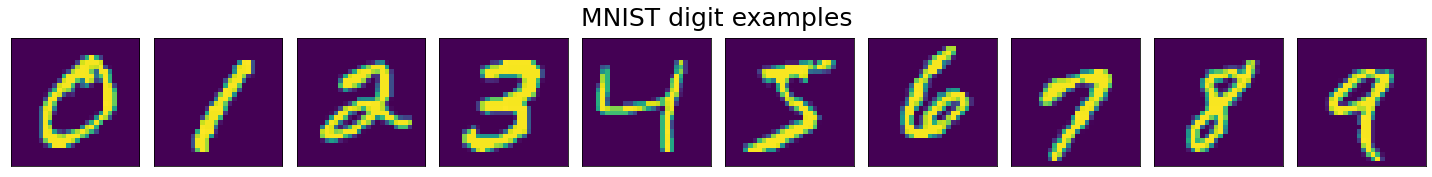

In [6]:
plt.figure(figsize=(20, 5))

rows = 1
columns = 10

for i in range(rows*columns):
    ax = plt.subplot(rows, columns, i + 1)
    for j,v in enumerate(images):
        if labels[j] == i:
            image = np.array(v).reshape(28,28)
            ax.imshow(image)
            ax.set_xticks(())
            ax.set_yticks(())
            break

plt.suptitle('MNIST digit examples', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=1.4)
# plt.savefig('plots/digits.png')

#### Examine variability of hand-written 5 digits.

In [7]:
fives = []
integer = 5
for i,v in enumerate(labels):
    if v == integer:
        fives.append(images[i])

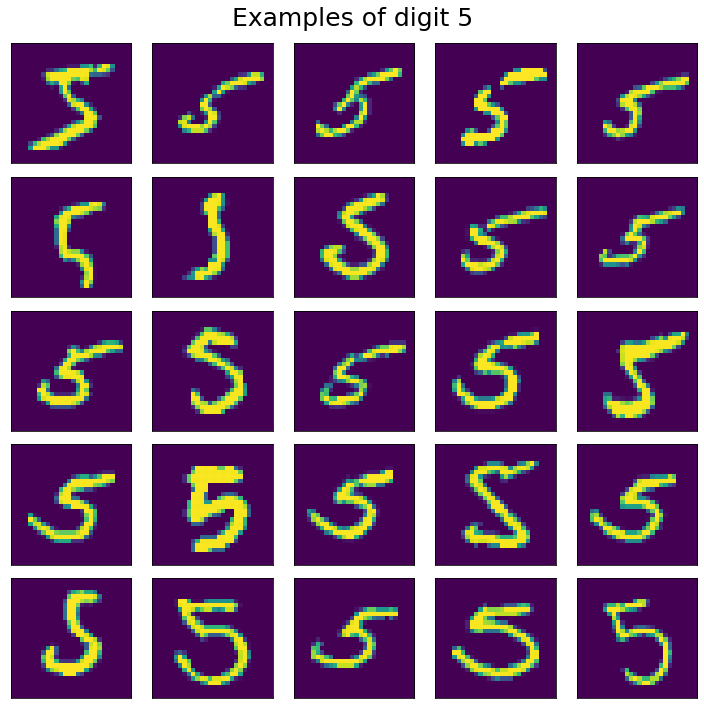

In [8]:
plt.figure(figsize=(10, 10))

rows = 5
columns = 5

for i in range(rows*columns):
    ax = plt.subplot(rows, columns, i + 1)
    image = np.array(fives[i]).reshape(28,28)
    ax.imshow(image)
    ax.set_xticks(())
    ax.set_yticks(())
    
plt.suptitle('Examples of digit 5', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
# plt.savefig('plots/fives.png')

# Logistic Regression Model Fitting

## NumPy solution

In [9]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#### Create boolean arrays for each integer type.

In [10]:
def bool_array(B):
    y = []

    for i in range(10):
        array = []
        for index, value in enumerate(B):
            if value == i:
                array.append(1)
            else:
                array.append(0)


        y.append(array)
        
    y = np.array(y)
    
    return y

In [11]:
y = bool_array(labels)
y_test = bool_array(labels_test)

In [12]:
X = images
X_test = images_test

#### Build model.

In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [14]:
def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [15]:
def fit(X, y, num_iter=100, loss_rate=0.01):
    intercept = np.ones((X.shape[0], 1))
    X = np.concatenate((intercept, X), axis=1)
    theta = np.zeros(X.shape[1])
    for i in range(num_iter):
        z = np.dot(X, theta)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        theta -= loss_rate * gradient    
    return theta

In [16]:
def predict_prob(X, theta, B_validation, threshold=0.5):
    intercept = np.ones((X.shape[0], 1))
    X = np.concatenate((intercept, X), axis=1)
    B = sigmoid(np.dot(X, theta))
    B = B >= threshold
    return B

In [17]:
def build_model(X, y, num_iter=100, loss_rate=0.01):
    coefficients = []
    for i, v in enumerate(y):
        theta = fit(X, v, num_iter=num_iter, loss_rate=loss_rate)
        coefficients.append(theta)
    return np.array(coefficients)

In [18]:
def validate_model(coefficients, X_test, y_test):
    B = []
    scores = []
    for i, v in enumerate(y_test):
        Bn = predict_prob(X_test, coefficients[i], v)
        score = (Bn == v).mean()
        scores.append(score)
        B.append(Bn)
        
    scores = np.array(scores)
    
    return np.array(B), scores.mean(), scores

In [19]:
%time coefficients = build_model(X, y, num_iter=100, loss_rate=0.01)

CPU times: user 5min 12s, sys: 3.61 s, total: 5min 15s
Wall time: 41.4 s


In [20]:
sparsity = np.mean(np.array(coefficients) == 0) * 100
predictions, score, scores = validate_model(coefficients, X_test, y_test)

In [21]:
sparsity

8.535031847133757

In [22]:
score

0.96136

#### Plot diagonal of confusion matrix.

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [24]:
cm = np.zeros((10,10))
np.fill_diagonal(cm, scores)

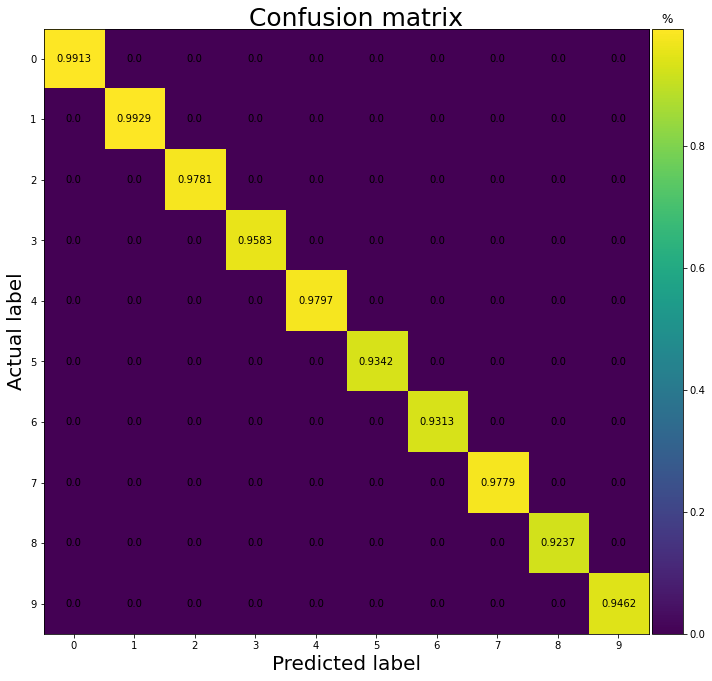

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

tick_marks = np.arange(10)
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('Actual label',fontsize=20)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)


im = plt.imshow(cm, interpolation='nearest', cmap='viridis')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im, cax=cax)
clb.ax.set_title('%')

plt.suptitle('Confusion matrix', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=1)

width, height = cm.shape
for x in range(width):
    for y in range(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center')

# plt.savefig('plots/np_confusion_matrix.png')

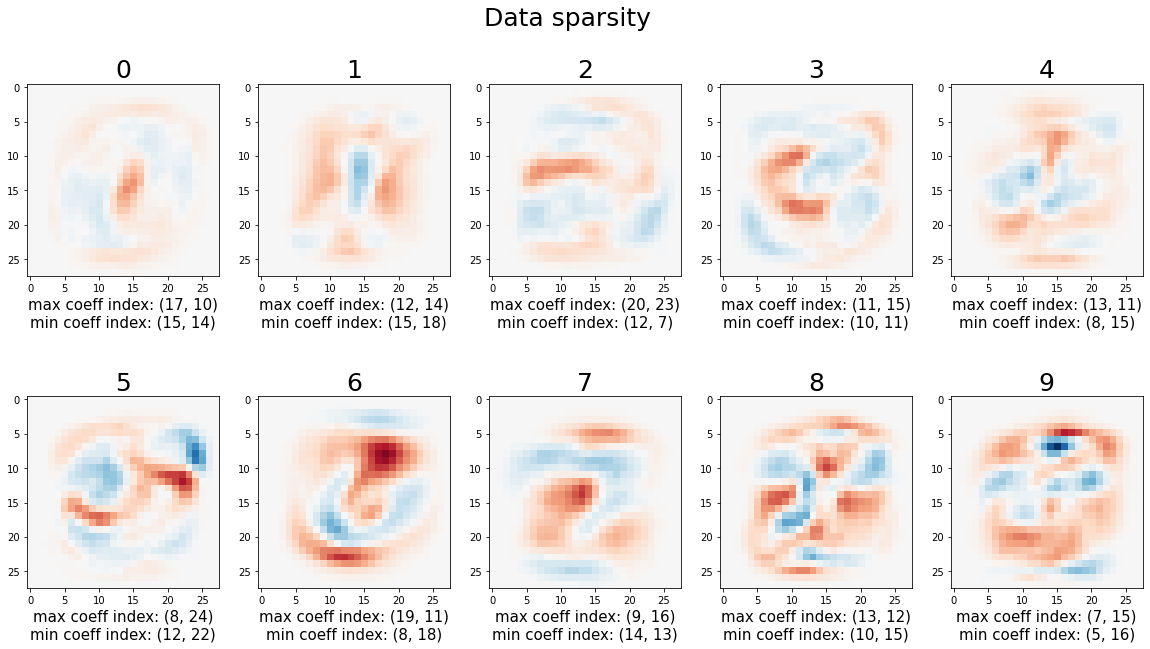

In [26]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    image = coefficients[i][1:].reshape(28, 28)
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image, 
              interpolation='nearest',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    max_coeff_index = str(np.unravel_index(image.argmax(), image.shape)) 
    min_coeff_index = str(np.unravel_index(image.argmin(), image.shape)) 
    
    ax.set_title(str(i),fontsize=25)
    
    text = 'max coeff index: ' + max_coeff_index + '\nmin coeff index: ' + min_coeff_index
    ax.set_xlabel(text,fontsize=15)
    
plt.suptitle('Data sparsity', fontsize=25)
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/np_sparsity.png')

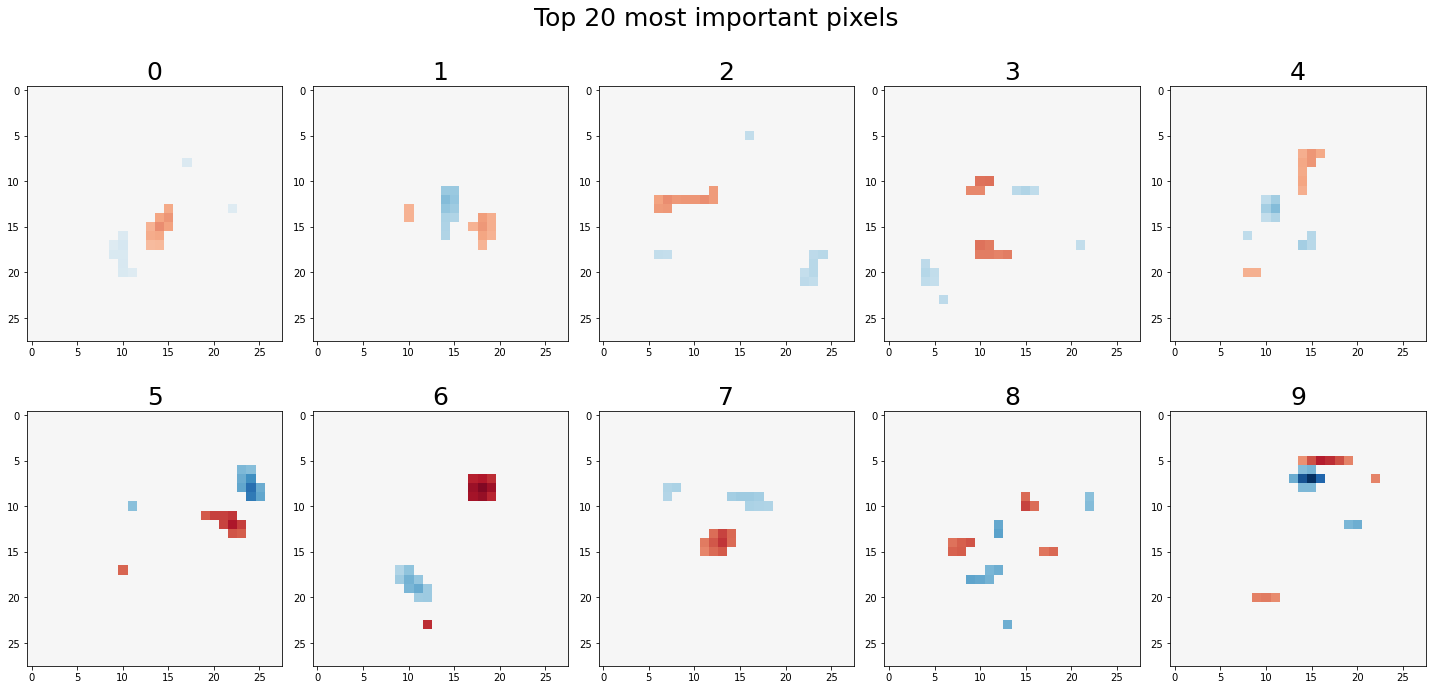

In [27]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    
    img = np.zeros((28,28))
    image = coefficients[i][1:].reshape(28, 28)
    
    for j in range(10):
        max_idx = np.unravel_index(image.argmax(), image.shape)
        min_idx = np.unravel_index(image.argmin(), image.shape)
        
        val = image[max_idx]
        img[max_idx] = val
        image[max_idx] = 0
        
        val = image[min_idx]
        img[min_idx] = val
        image[min_idx] = 0
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(img, 
              interpolation='none',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    
    ax.set_title(str(i),fontsize=25)
    
    
plt.suptitle('Top 20 most important pixels', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/np_sparsity_top20.png')

## scikit-learn solution

In [28]:
mndata = MNIST('./')

images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels.tolist())

images_test, labels_test = mndata.load_testing()
images_test = np.array(images_test)
labels_test = np.array(labels_test.tolist())

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#### Transform data by scaling and centering around mean.

In [30]:
scaler = StandardScaler()

In [31]:
A = scaler.fit_transform(images)
B = np.array(labels)

In [32]:
A_test = scaler.transform(images_test)
B_test = np.array(labels_test)

#### Fit logistic regression model to data with L1 penality to promote sparcity.
**C**      = Sets regularization strength. Smaller value results in stronger regularization and greater sparsity.  
**tol**    = Tolerance threshold to stop optimization.  
**solver** = 'saga' Stochastic Average Gradient descent algorithm. Aggregate gradient descent approach that uses random sample of previous gradient values for optimization.

In [33]:
X = LogisticRegression(C=0.005, 
                       penalty='l1', 
                       solver='saga', 
                       tol=0.01)

%time X.fit(A, B)

coefficients = X.coef_.copy()
sparsity = np.mean(coefficients == 0) * 100
predictions = X.predict(A_test)
score = X.score(A_test, B_test)

CPU times: user 1min 51s, sys: 83.7 ms, total: 1min 51s
Wall time: 1min 51s


In [34]:
sparsity

73.09948979591837

In [35]:
score

0.899

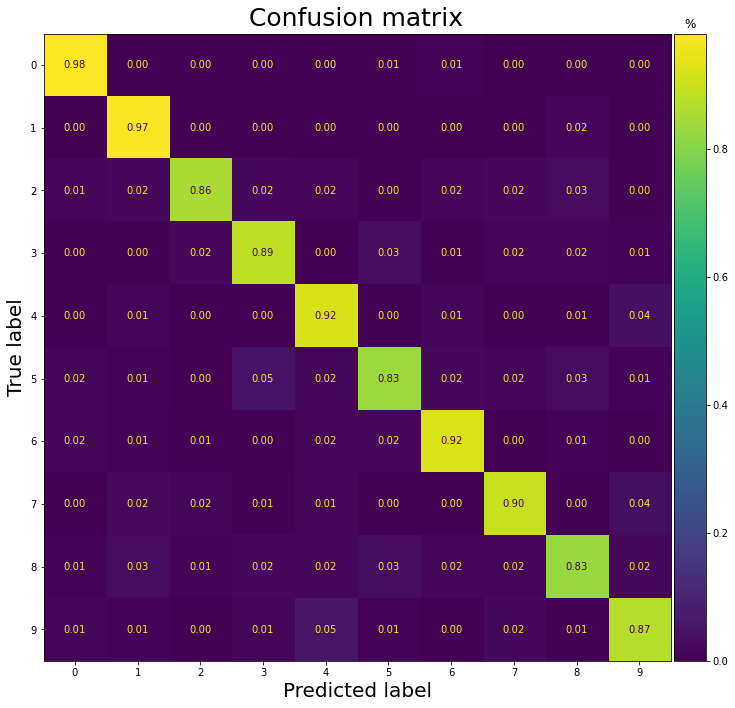

In [36]:
fig, ax = plt.subplots(figsize=(10,10))

plt.xlabel('',fontsize=20)
plt.ylabel('',fontsize=20)

im = metrics.plot_confusion_matrix(X, 
                              A_test, 
                              B_test, 
                              ax=ax, 
                              values_format = '.2f',
                              normalize='true')
im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%')

plt.suptitle('Confusion matrix', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=1)
# plt.savefig('plots/confusion_matrix.png')

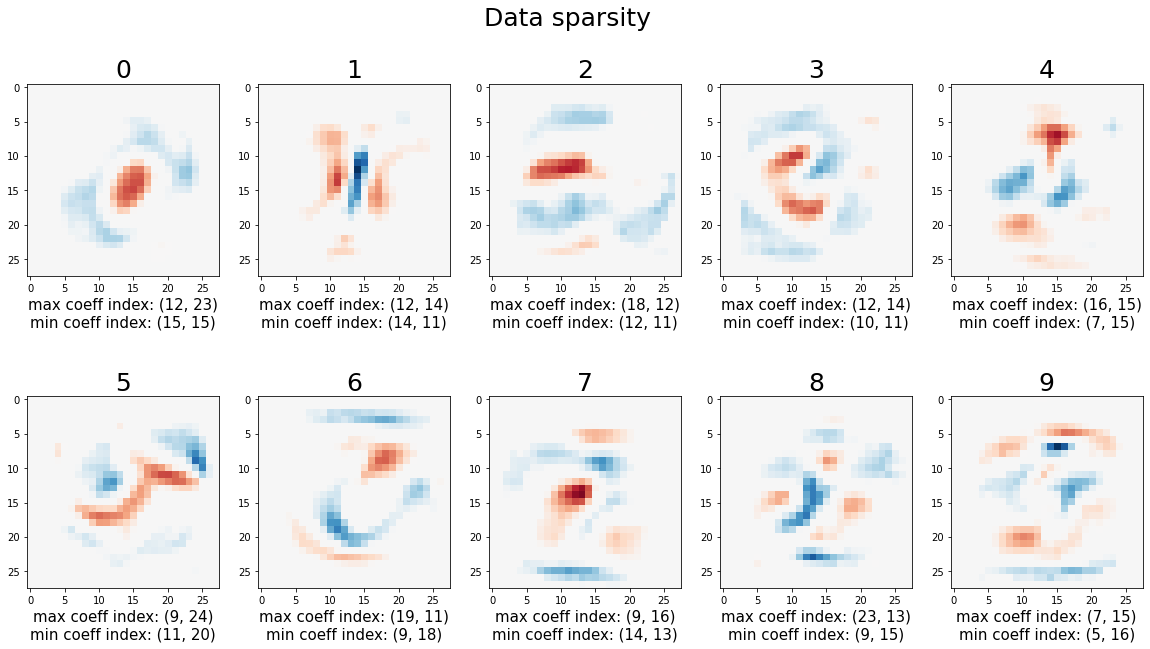

In [37]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    image = coefficients[i].reshape(28, 28)
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image, 
              interpolation='nearest',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    max_coeff_index = str(np.unravel_index(image.argmax(), image.shape)) 
    min_coeff_index = str(np.unravel_index(image.argmin(), image.shape)) 
    
    ax.set_title(str(i),fontsize=25)
    
    text = 'max coeff index: ' + max_coeff_index + '\nmin coeff index: ' + min_coeff_index
    ax.set_xlabel(text,fontsize=15)
    
plt.suptitle('Data sparsity', fontsize=25)
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/sparsity.png')

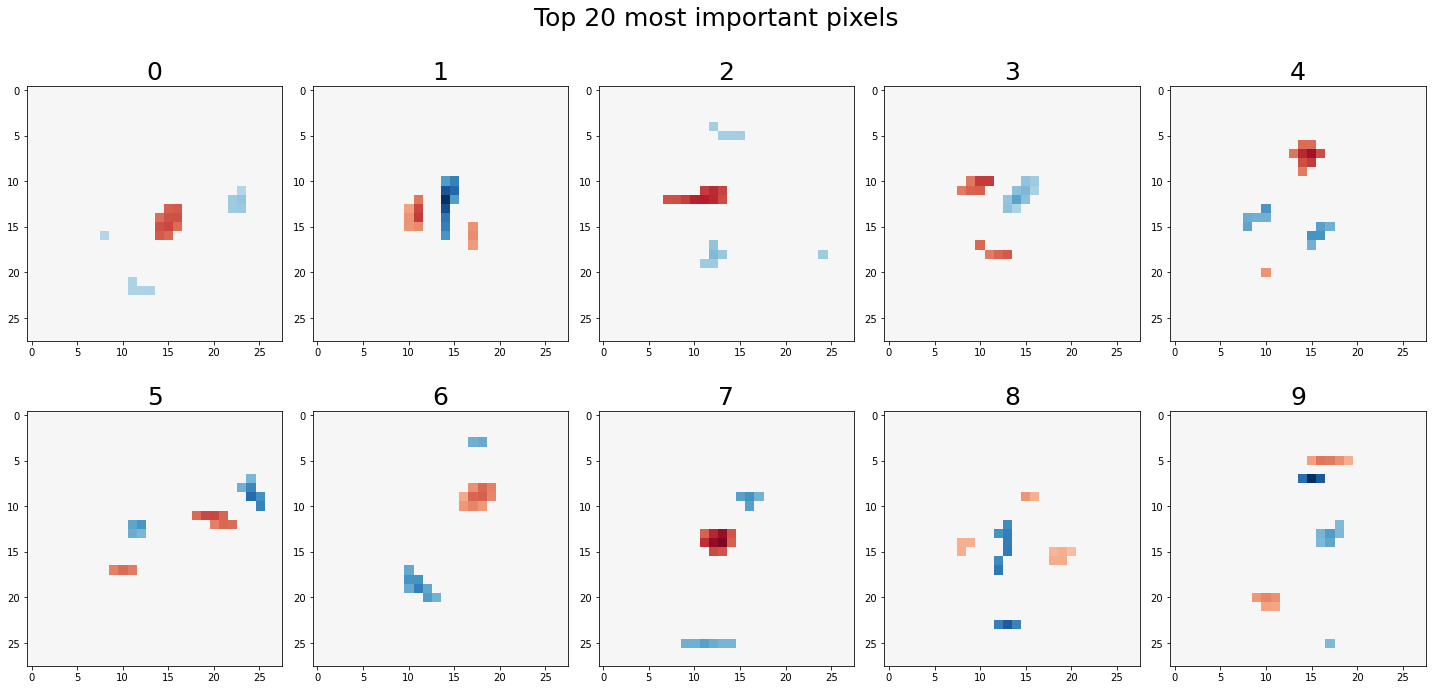

In [38]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    
    img = np.zeros((28,28))
    image = coefficients[i].reshape(28, 28)
    
    for j in range(10):
        max_idx = np.unravel_index(image.argmax(), image.shape)
        min_idx = np.unravel_index(image.argmin(), image.shape)
        
        val = image[max_idx]
        img[max_idx] = val
        image[max_idx] = 0
        
        val = image[min_idx]
        img[min_idx] = val
        image[min_idx] = 0
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(img, 
              interpolation='none',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    
    ax.set_title(str(i),fontsize=25)
    
    
plt.suptitle('Top 20 most important pixels', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/sparsity_top20.png')

# Data reduction

In [39]:
mndata = MNIST('./')

images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels.tolist())

images_test, labels_test = mndata.load_testing()
images_test = np.array(images_test)
labels_test = np.array(labels_test.tolist())

In [40]:
grouped_image_classes = []

for i in range(10):
    image_class = []
    for index, value in enumerate(labels):
        if value == i:
            image_class.append(images[index])
    grouped_image_classes.append(image_class)
    
grouped_image_classes = np.array(grouped_image_classes)

In [41]:
masked_images = A.copy()

for i in range(10):
    mask = [coefficients[i] != 0]
    
    for index, value in enumerate(labels):
        if value == i:
            masked_images[index][mask] = 0

In [42]:
A = masked_images

In [43]:
X = LogisticRegression(C=0.005, 
                       penalty='l1', 
                       solver='saga', 
                       tol=0.01)

%time X.fit(A, B)

coefficients = X.coef_.copy()
sparsity = np.mean(coefficients == 0) * 100
predictions = X.predict(A_test)
score = X.score(A_test, B_test)

CPU times: user 2min 35s, sys: 116 ms, total: 2min 35s
Wall time: 2min 35s


In [44]:
sparsity

86.68367346938776

In [45]:
score

0.8138

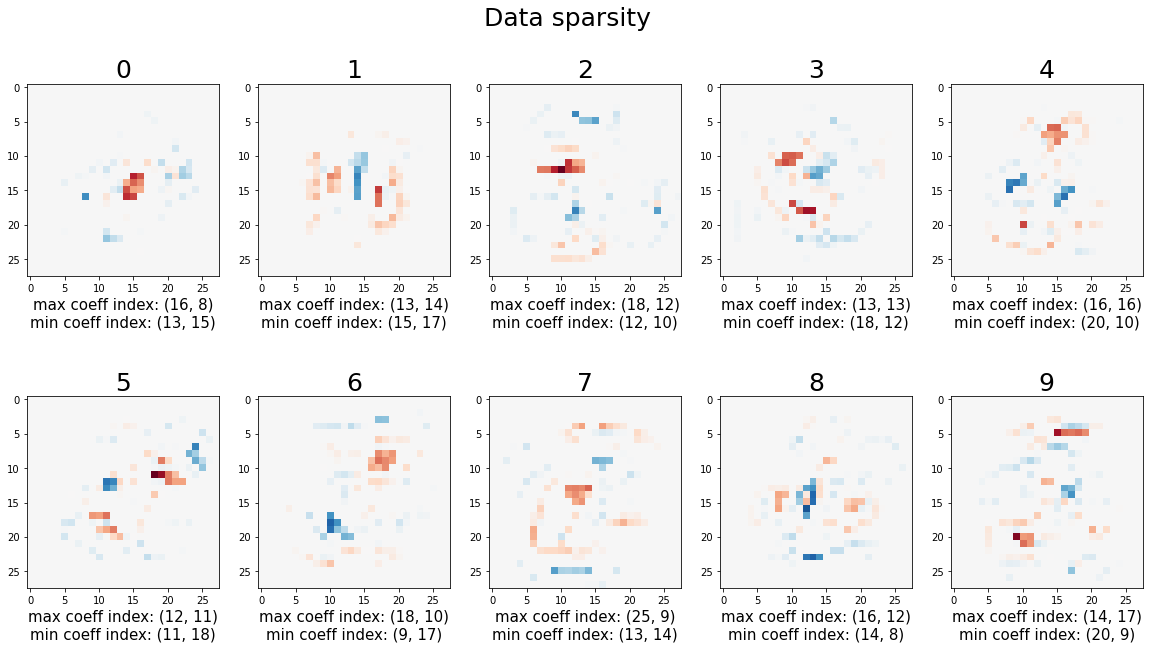

In [46]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    image = coefficients[i].reshape(28, 28)
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image, 
              interpolation='nearest',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    max_coeff_index = str(np.unravel_index(image.argmax(), image.shape)) 
    min_coeff_index = str(np.unravel_index(image.argmin(), image.shape)) 
    
    ax.set_title(str(i),fontsize=25)
    
    text = 'max coeff index: ' + max_coeff_index + '\nmin coeff index: ' + min_coeff_index
    ax.set_xlabel(text,fontsize=15)
    
plt.suptitle('Data sparsity', fontsize=25)
plt.subplots_adjust(top=0.92)

In [47]:
import sparse

In [48]:
A = scaler.fit_transform(images)

In [49]:
A[0].nbytes

6272

In [50]:
s = sparse.COO.from_numpy(A[0], fill_value=0)
s1 = s.data.nbytes

In [51]:
s = sparse.COO.from_numpy(masked_images[0], fill_value=0)
s2 = s.data.nbytes

In [52]:
(1 - s2/s1) * 100

26.080892608089258

# Exploring Lasso and ElasticNet regression models with L1 penalty

In [53]:
mndata = MNIST('./')

images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels.tolist())

images_test, labels_test = mndata.load_testing()
images_test = np.array(images_test)
labels_test = np.array(labels_test.tolist())

## Lasso regression

In [54]:
from sklearn.linear_model import Lasso
# from sklearn.metrics import r2_score

In [55]:
def run_lasso(X_train, y_train, X_test, y_test, alpha):
    lasso = Lasso(alpha=alpha)
    y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
#     r2_score = r2_score(y_test, y_pred_lasso)

    predictions = np.around(y_pred_lasso)
    score = (predictions == y_test).mean()
    
    coefficients = lasso.coef_
    
    sparsity = np.mean(coefficients == 0) * 100
    
    print('Sparsity: ' + str(round(sparsity, 2)) + '\nScore: '+ str(round(score * 100, 2)))
    
    return sparsity, score * 100

#### Without transforming the data.

In [56]:
X_train = images
y_train = labels

X_test = images_test
y_test = labels_test

In [57]:
alphas = [10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
sparsities = []
scores = []
for i in alphas:
    alpha = i
    print('Alpha: ' + str(alpha))
    %time sparsity, score = run_lasso(X_train, y_train, X_test, y_test, alpha)
    print('\n')
    
    scores.append(score)
    sparsities.append(sparsity)

Alpha: 10
Sparsity: 89.41
Score: 16.07
CPU times: user 12.6 s, sys: 390 ms, total: 13 s
Wall time: 2.53 s


Alpha: 5
Sparsity: 84.18
Score: 17.05
CPU times: user 24.2 s, sys: 2.92 s, total: 27.1 s
Wall time: 5.34 s


Alpha: 1
Sparsity: 70.15
Score: 20.55
CPU times: user 23.4 s, sys: 651 ms, total: 24 s
Wall time: 3.87 s


Alpha: 0.5
Sparsity: 63.65
Score: 21.41
CPU times: user 27.1 s, sys: 619 ms, total: 27.7 s
Wall time: 4.36 s


Alpha: 0.1
Sparsity: 47.32
Score: 21.78
CPU times: user 1min 6s, sys: 906 ms, total: 1min 7s
Wall time: 9.46 s


Alpha: 0.05
Sparsity: 39.54
Score: 21.86
CPU times: user 1min 26s, sys: 1.2 s, total: 1min 27s
Wall time: 12 s


Alpha: 0.01
Sparsity: 26.53
Score: 22.04
CPU times: user 2min 29s, sys: 2.05 s, total: 2min 31s
Wall time: 20.3 s


Alpha: 0.005
Sparsity: 21.05
Score: 22.09
CPU times: user 3min 14s, sys: 2.77 s, total: 3min 17s
Wall time: 26.3 s


Alpha: 0.001
Sparsity: 13.65
Score: 22.07
CPU times: user 4min 49s, sys: 4.05 s, total: 4min 53s
Wall time

Text(0, 0.5, 'Score (hit %)')

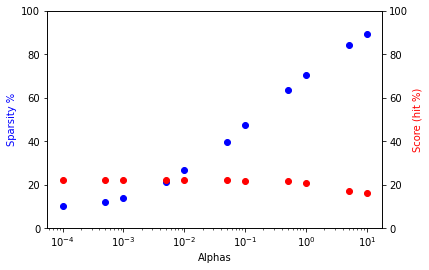

In [58]:
fig, ax1 = plt.subplots()
ax1.scatter(alphas, sparsities, color='b')
ax1.set_xlabel('Alphas')
ax1.set_ylabel('Sparsity %', color='b')

ax1.set_xscale('log')
ax1.set_ylim([0,100])

ax2 = ax1.twinx()
ax2.set_ylim([0,100])

ax2.scatter(alphas, scores, color='r')
ax2.set_ylabel('Score (hit %)', color='r')

#### With data transform prior to processing.

In [59]:
scaler = StandardScaler()

X_train = scaler.fit_transform(images)
y_train = np.array(labels)

X_test = scaler.transform(images_test)
y_test = np.array(labels_test)

In [60]:
sparsities = []
scores = []
for i in alphas:
    alpha = i
    print('Alpha: ' + str(alpha))
    %time sparsity, score = run_lasso(X_train, y_train, X_test, y_test, alpha)
    print('\n')
    
    scores.append(score)
    sparsities.append(sparsity)

Alpha: 10
Sparsity: 100.0
Score: 9.82
CPU times: user 1.8 s, sys: 337 ms, total: 2.14 s
Wall time: 1.42 s


Alpha: 5
Sparsity: 100.0
Score: 9.82
CPU times: user 2.97 s, sys: 388 ms, total: 3.36 s
Wall time: 1.36 s


Alpha: 1
Sparsity: 99.74
Score: 4.01
CPU times: user 4.36 s, sys: 341 ms, total: 4.7 s
Wall time: 1.48 s


Alpha: 0.5
Sparsity: 97.83
Score: 5.9
CPU times: user 7.64 s, sys: 396 ms, total: 8.04 s
Wall time: 1.89 s


Alpha: 0.1
Sparsity: 86.61
Score: 16.72
CPU times: user 16.1 s, sys: 471 ms, total: 16.6 s
Wall time: 2.99 s


Alpha: 0.05
Sparsity: 77.04
Score: 18.14
CPU times: user 18.3 s, sys: 605 ms, total: 18.9 s
Wall time: 3.37 s


Alpha: 0.01
Sparsity: 57.91
Score: 20.94
CPU times: user 31 s, sys: 696 ms, total: 31.7 s
Wall time: 5.05 s


Alpha: 0.005
Sparsity: 46.81
Score: 21.62
CPU times: user 47.3 s, sys: 1.17 s, total: 48.4 s
Wall time: 7.44 s


Alpha: 0.001
Sparsity: 25.26
Score: 21.72
CPU times: user 1min 30s, sys: 1.44 s, total: 1min 31s
Wall time: 12.9 s


Alpha

Text(0, 0.5, 'Score (hit %)')

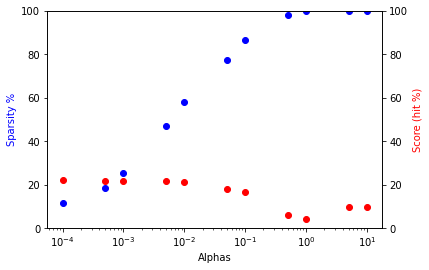

In [61]:
fig, ax1 = plt.subplots()
ax1.scatter(alphas, sparsities, color='b')
ax1.set_xlabel('Alphas')
ax1.set_ylabel('Sparsity %', color='b')

ax1.set_xscale('log')
ax1.set_ylim([0,100])

ax2 = ax1.twinx()
ax2.set_ylim([0,100])

ax2.scatter(alphas, scores, color='r')
ax2.set_ylabel('Score (hit %)', color='r')

## Elastic Net regression

In [62]:
from sklearn.linear_model import ElasticNet

In [63]:
def run_elasticNet(X_train, y_train, X_test, y_test, alpha, l1_ratio):
    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
#     r2_score = r2_score(y_test, y_pred_enet)
    
    predictions = np.around(y_pred_enet)
    score = (predictions == y_test).mean()
    
    coefficients =  enet.coef_
    sparsity = np.mean(coefficients == 0) * 100
    print('Sparsity: ' + str(round(sparsity, 2)) + '\nScore: '+ str(round(score * 100, 2)))
    
    return sparsity, score * 100

In [64]:
X_train = images
y_train = labels

X_test = images_test
y_test = labels_test

In [65]:
%%time
sparsities = []
scores = []
l1_ratios = [1, 0.5, 0.1, 0.01]

for i in alphas:
    alpha = i
    print('Alpha: ' + str(alpha) + '\n')
    for j in l1_ratios:
        l1_ratio = j
        print('L1 ratio: ' + str(l1_ratio))
#         %time sparsity, score = run_elasticNet(X_train, y_train, X_test, y_test, alpha, l1_ratio)
        sparsity, score = run_elasticNet(X_train, y_train, X_test, y_test, alpha, l1_ratio)
#         print('\n')
        scores.append(score)
        sparsities.append(sparsity)
    print('\n')

Alpha: 10

L1 ratio: 1
Sparsity: 89.41
Score: 16.07
L1 ratio: 0.5
Sparsity: 84.18
Score: 17.05
L1 ratio: 0.1
Sparsity: 69.64
Score: 20.49
L1 ratio: 0.01
Sparsity: 45.92
Score: 21.69


Alpha: 5

L1 ratio: 1
Sparsity: 84.18
Score: 17.05
L1 ratio: 0.5
Sparsity: 79.08
Score: 18.49
L1 ratio: 0.1
Sparsity: 63.52
Score: 21.34
L1 ratio: 0.01
Sparsity: 39.16
Score: 21.84


Alpha: 1

L1 ratio: 1
Sparsity: 70.15
Score: 20.55
L1 ratio: 0.5
Sparsity: 63.65
Score: 21.41
L1 ratio: 0.1
Sparsity: 47.19
Score: 21.75
L1 ratio: 0.01
Sparsity: 25.77
Score: 22.05


Alpha: 0.5

L1 ratio: 1
Sparsity: 63.65
Score: 21.41
L1 ratio: 0.5
Sparsity: 56.63
Score: 21.54
L1 ratio: 0.1
Sparsity: 39.67
Score: 21.86
L1 ratio: 0.01
Sparsity: 20.41
Score: 22.11


Alpha: 0.1

L1 ratio: 1
Sparsity: 47.32
Score: 21.78
L1 ratio: 0.5
Sparsity: 39.54
Score: 21.86
L1 ratio: 0.1
Sparsity: 26.4
Score: 22.03
L1 ratio: 0.01
Sparsity: 13.01
Score: 22.1


Alpha: 0.05

L1 ratio: 1
Sparsity: 39.54
Score: 21.86
L1 ratio: 0.5
Sparsity: 33.6

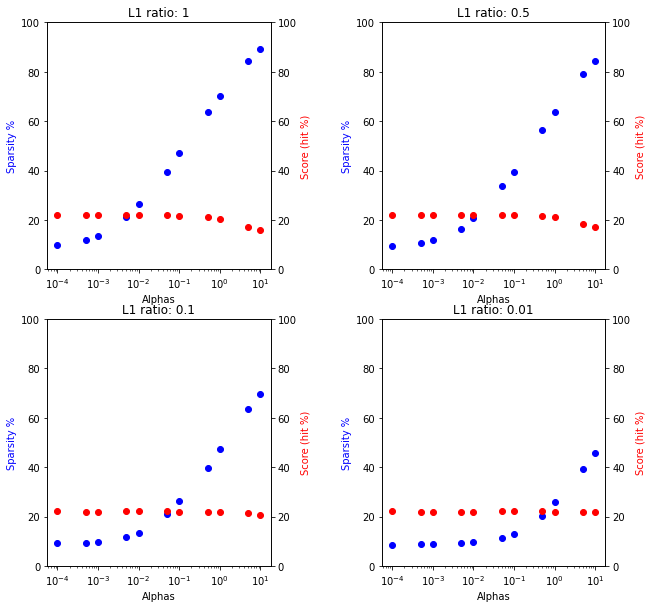

In [66]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)

for i, v in enumerate(l1_ratios):
        
    ax1 = plt.subplot(2, 2, i + 1)
    ax1.set_title('L1 ratio: ' + str(v))

    ax1.scatter(alphas, np.array(sparsities)[i::4], color='b')
    ax1.set_xlabel('Alphas')
    ax1.set_ylabel('Sparsity %', color='b')

    ax1.set_xscale('log')
    ax1.set_ylim([0,100])

    ax2 = ax1.twinx()
    ax2.set_ylim([0,100])

    ax2.scatter(alphas, np.array(scores)[i::4], color='r')
    ax2.set_ylabel('Score (hit %)', color='r')

#### With data transform prior to processing.

In [67]:
scaler = StandardScaler()

X_train = scaler.fit_transform(images)
y_train = np.array(labels)

X_test = scaler.transform(images_test)
y_test = np.array(labels_test)

In [68]:
%%time
sparsities = []
scores = []

for i in alphas:
    alpha = i
    print('Alpha: ' + str(alpha) + '\n')
    for j in l1_ratios:
        l1_ratio = j
        print('L1 ratio: ' + str(l1_ratio))
#         %time sparsity, score = run_elasticNet(X_train, y_train, X_test, y_test, alpha, l1_ratio)
        sparsity, score = run_elasticNet(X_train, y_train, X_test, y_test, alpha, l1_ratio)
#         print('\n')
        scores.append(score)
        sparsities.append(sparsity)
    print('\n')

Alpha: 10

L1 ratio: 1
Sparsity: 100.0
Score: 9.82
L1 ratio: 0.5
Sparsity: 100.0
Score: 9.82
L1 ratio: 0.1
Sparsity: 99.36
Score: 3.83
L1 ratio: 0.01
Sparsity: 57.14
Score: 8.87


Alpha: 5

L1 ratio: 1
Sparsity: 100.0
Score: 9.82
L1 ratio: 0.5
Sparsity: 100.0
Score: 9.82
L1 ratio: 0.1
Sparsity: 92.47
Score: 3.32
L1 ratio: 0.01
Sparsity: 48.47
Score: 13.41


Alpha: 1

L1 ratio: 1
Sparsity: 99.74
Score: 4.01
L1 ratio: 0.5
Sparsity: 95.92
Score: 4.67
L1 ratio: 0.1
Sparsity: 73.34
Score: 15.31
L1 ratio: 0.01
Sparsity: 34.44
Score: 17.9


Alpha: 0.5

L1 ratio: 1
Sparsity: 97.83
Score: 5.9
L1 ratio: 0.5
Sparsity: 91.58
Score: 11.71
L1 ratio: 0.1
Sparsity: 65.69
Score: 17.35
L1 ratio: 0.01
Sparsity: 27.81
Score: 19.06


Alpha: 0.1

L1 ratio: 1
Sparsity: 86.61
Score: 16.72
L1 ratio: 0.5
Sparsity: 73.98
Score: 18.0
L1 ratio: 0.1
Sparsity: 50.13
Score: 20.44
L1 ratio: 0.01
Sparsity: 19.52
Score: 20.92


Alpha: 0.05

L1 ratio: 1
Sparsity: 77.04
Score: 18.14
L1 ratio: 0.5
Sparsity: 68.49
Score: 19

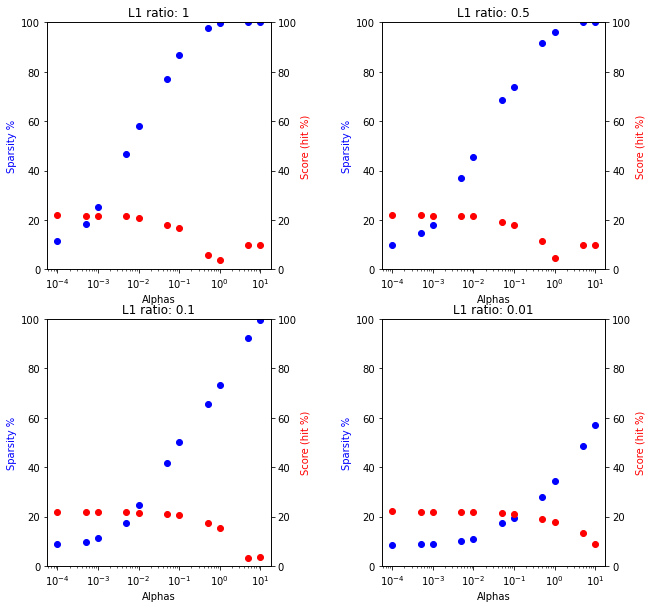

In [69]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)

for i, v in enumerate(l1_ratios):
        
    ax1 = plt.subplot(2, 2, i + 1)
    ax1.set_title('L1 ratio: ' + str(v))

    ax1.scatter(alphas, np.array(sparsities)[i::4], color='b')
    ax1.set_xlabel('Alphas')
    ax1.set_ylabel('Sparsity %', color='b')

    ax1.set_xscale('log')
    ax1.set_ylim([0,100])

    ax2 = ax1.twinx()
    ax2.set_ylim([0,100])

    ax2.scatter(alphas, np.array(scores)[i::4], color='r')
    ax2.set_ylabel('Score (hit %)', color='r')